In [37]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append('../')
import config
import warnings
warnings.filterwarnings('ignore')

In [38]:
df = pd.read_csv('../../data/data_daily_with_aqi.csv')
target = 'AQI'
city ='北京'
df_tgt = df[df.type==target].drop('type',axis=1)
df_tgt_ct = df_tgt[['date',city]].rename(columns={'date':'ds',city:'y'})
df_tgt_ct = df_tgt_ct.dropna()

In [39]:
from statsmodels.tsa.stattools import adfuller
adfuller(df_tgt_ct['y'])

(-5.4251242562740325,
 2.9990413272316225e-06,
 23,
 2561,
 {'1%': -3.4329059807036155,
  '5%': -2.8626692305213957,
  '10%': -2.5673711311351712},
 28249.92521076872)

In [40]:

model = pm.auto_arima(df_tgt_ct['y'], start_p=1, start_q=1,
                      information_criterion='aic',
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=10, max_q=10,max_d=10, # maximum p and q
                      start_d=1,
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=True,   # No Seasonality
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=False, 
                      stepwise=True)



Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=28763.535, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=29490.235, Time=0.02 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=28767.189, Time=0.04 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=28926.297, Time=0.62 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=31802.386, Time=0.01 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=28656.728, Time=2.04 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=28764.955, Time=0.20 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=28656.592, Time=1.55 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=28759.106, Time=0.18 sec
 ARIMA(4,0,1)(0,0,0)[0] intercept   : AIC=28743.996, Time=0.56 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=28747.258, Time=1.39 sec
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=28679.188, Time=1.29 sec
 ARIMA(4,0,0)(0,0,0)[0] intercept   : AIC=28742.254, Time=0.18 sec
 ARIMA(4,0,2)(0,0,0)[0] intercept   : AIC=28736.459, Time=1.64 sec
 ARIMA(3,0,1)(0,0,0

In [41]:
print(model.order)

(3, 0, 1)


In [42]:
print(model.seasonal_order)

(0, 0, 0, 0)


In [43]:
print(model.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2585
Model:               SARIMAX(3, 0, 1)   Log Likelihood              -14322.296
Date:                Fri, 20 May 2022   AIC                          28656.592
Time:                        14:33:31   BIC                          28691.737
Sample:                             0   HQIC                         28669.329
                               - 2585                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      1.2645      0.466      2.711      0.007       0.350       2.179
ar.L1          1.3549      0.020     66.779      0.000       1.315       1.395
ar.L2         -0.4230      0.024    -17.637      0.0

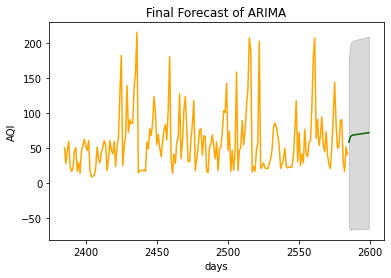

In [44]:
y = df_tgt_ct.y.reset_index(drop=True)
# Forecast
n_periods = 15
fc, confint = model.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = np.arange(len(df_tgt_ct.y), len(df_tgt_ct.y)+n_periods)

# make series for plotting purpose
fc_series = pd.Series(fc, index=index_of_fc)
lower_series = pd.Series(confint[:, 0], index=index_of_fc)
upper_series = pd.Series(confint[:, 1], index=index_of_fc)

# Plot
plt.plot(y[-200:],color = 'orange')
plt.plot(fc_series, color='darkgreen')
plt.fill_between(lower_series.index, 
                 lower_series, 
                 upper_series, 
                 color='k', alpha=.15)
plt.xlabel('days')
plt.ylabel(target)
plt.title("Final Forecast of ARIMA")
plt.show()